In [2]:
import sys  
sys.path.insert(1, 'C:/Users/Kinga/Desktop/MAGISTERKA/code')

from clustering_script import *
from graph_generating_script import *

In [3]:
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import igraph as ig
import community
from graph_generating_script import *


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_best_num_clusters(data, max_clusters=10):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters


from sklearn.cluster import AgglomerativeClustering, OPTICS


def get_clusters_from_positions(G, posdf, best_num, true_labels, k=1):
    #agglomerative clustering
    scores = []
    # for i in range(k):
    model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.labels_)
    # scores[0] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #DBscan
    model = OPTICS()
    model.fit(posdf)
    yhat= list(model.labels_)
    # scores[1] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    # kmeans
    model = KMeans(n_clusters=best_num, random_state=212)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[2] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #GMM
    from sklearn.mixture import GaussianMixture
    #modeling
    model = GaussianMixture(n_components=best_num, random_state=212).fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[3] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #Birch
    model = Birch(n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[4] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    # communities = girvan_newman(G)

    #community detections

    #Girvan Newman
    # communities = girvan_newman(G)
    # comms = []
    # for com in next(communities):
    #     comms.append(list(com))
    # list_comms = [None] * len(G.nodes)
    # for i in range(len(comms)):
    #     com = comms[i]
    #     for node in com:
    #         list_comms[node] = i

    #separate tool to choose number of communities for girvan newman
    partition = community.best_partition(G)
    num_communities = len(set(partition.values()))
    # print(f'Number for communities for Girvan Newman: {num_communities}')
    G1 = G.copy()
    
    while nx.number_connected_components(G1) < num_communities:
        edge_centrality = nx.edge_betweenness_centrality(G1)
        max_edge = max(edge_centrality, key=edge_centrality.get)
        G1.remove_edge(*max_edge)
    
    communities = list(nx.connected_components(G1))
    comms = []
    for com in communities:
        comms.append(list(com))
    list_comms = [None] * len(G.nodes)
    for i in range(len(comms)):
        com = comms[i]
        for node in com:
            list_comms[node] = i

    scores.append(adjusted_rand_score(true_labels, list_comms))
    # scores[5] += adjusted_rand_score(true_labels, list_comms)

    #Leiden
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
    partition = G_ig.community_leiden(objective_function="modularity")
    list_comms = [None] * len(G.nodes)
    for i, com in enumerate(partition):
        for node in com:
            list_comms[node] = i

    # scores[6] += adjusted_rand_score(true_labels, list_comms)
    scores.append(adjusted_rand_score(true_labels, list_comms))
    return scores

def add_scores(df, scores, layout_name='spring'):
    scores.insert(0, layout_name)
    data = df.to_dict('records')
    data.append(dict(zip(df.columns, scores)))
    df = pd.DataFrame(data)
    return df

def scaling_igraph(layout):
    coords = np.array(layout.coords)
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    scaled_coords = 2 * (coords - min_coords) / (max_coords - min_coords) - 1
    posdf = pd.DataFrame(scaled_coords, columns=['X', 'Y'])
    return posdf

def full_experiment_on_graph(G, true_labels):
    df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
    
    #for every layout
    #kamada kawai
    pos = nx.kamada_kawai_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    # print(f'Best number of clusters detected : {best_num}')
    scores = get_clusters_from_positions(G,posdf, best_num, true_labels)
    df = add_scores(df, scores, 'kamada_kawai')

    #spring layout
    pos = nx.spring_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G,posdf, best_num, true_labels)
    df = add_scores(df, scores, 'spring')

    #algorithms from igraph
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    #davidson harel
    layout = G_ig.layout('davidson_harel')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'davidson_harel')

    #drl
    layout = G_ig.layout('drl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'drl')

    # fruchterman reingold
    layout = G_ig.layout('fruchterman_reingold')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'fruchterman_reingold')

    #graphopt
    layout = G_ig.layout('graphopt')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'graphopt')

    #lgl
    layout = G_ig.layout('lgl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G,  posdf, best_num, true_labels)
    df = add_scores(df, scores, 'lgl')

    #mds
    layout = G_ig.layout('mds')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'mds')

    return df
            
def steady_full_experiment(sizes, inside_prob, outside_prob, k=5):

    (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
    df = full_experiment_on_graph(G, true_labels)
    # print("0")
    # print(df)
    for i in range(1,k):
        (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
        tmp = full_experiment_on_graph(G, true_labels)
        df[df.columns[1:]] += tmp[tmp.columns[1:]]

    df[df.columns[1:]] /= k
    return df
    

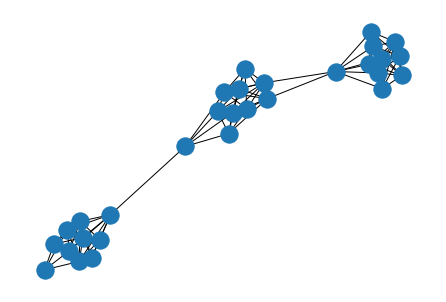

In [4]:
(G, true_labels) = generate_G([10,10,10], .8, .01)
nx.draw(G)


In [3]:
G.nodes[1]['community']

0

In [5]:
import networkx as nx

In [6]:
nx.numeric_assortativity_coefficient(G, "community")

0.957137239480928

In [ ]:
from sklearn.model_selection import ParameterGrid

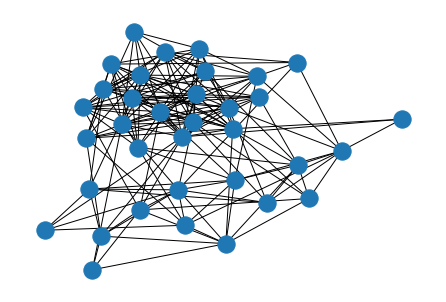

In [9]:
(G, true_labels) = generate_G([20, 10, 5], .5, .1)
nx.draw(G)


In [7]:
(G, true_labels) = generate_G([10, 20, 10, 5], .5, .1)

nx.numeric_assortativity_coefficient(G, "community")

0.23049794573886268

In [8]:
from sklearn.model_selection import ParameterGrid
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

# Define a range of resolution parameter values to search
resolutions = np.linspace(0.1, 2.0, 20)  # Adjust the range as needed

# Create a grid of parameter values to search
param_grid = {'resolution': resolutions}
grid = ParameterGrid(param_grid)

best_modularity = -np.inf
best_partition = None

# Iterate over each parameter combination
for params in grid:
    # Run Leiden algorithm with current parameter values
    partition = G_ig.community_leiden(objective_function="modularity", **params)
    
    # Calculate modularity of the partition
    modularity = G_ig.modularity(partition)
    
    # Update best modularity and partition if a better solution is found
    if modularity > best_modularity:
        best_modularity = modularity
        best_partition = partition

In [11]:
list_comms = [None] * len(G.nodes)
for i, com in enumerate(best_partition):
    for node in com:
        list_comms[node] = i

list_comms

[0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2]

In [11]:
steady_full_experiment([10, 20, 10, 5], .5, .1, 5)

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.359552,0.116610,0.485312,0.434533,0.376299,0.201706,0.096766
1,spring,0.417470,0.165398,0.492769,0.449115,0.208800,0.144194,0.106939
2,davidson_harel,0.065314,0.011112,0.061888,0.058622,0.054306,0.192651,0.089611
3,drl,0.031073,0.004522,0.017809,0.027861,0.007681,0.188762,0.106480
4,fruchterman_reingold,0.087698,0.065062,0.117594,0.089989,0.089343,0.167646,0.095571
5,graphopt,0.111748,0.058478,0.094858,0.086869,0.114383,0.192651,0.103734
6,lgl,-0.010127,0.056006,-0.010127,-0.010127,-0.002608,0.137514,0.120557
7,mds,0.097870,0.066954,0.125951,0.129267,0.075888,0.197504,0.091402


In [17]:
steady_full_experiment([10, 20, 10, 5], .5, .1, 5)

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.488317,0.075913,0.615562,0.493540,0.417849,0.128022,0.081946
1,spring,0.618064,0.134104,0.567746,0.595017,0.292294,0.149314,0.067360
2,davidson_harel,0.032229,-0.000483,0.036389,0.020191,0.036277,0.198364,0.055562
3,drl,-0.017668,-0.013003,0.011505,0.008943,0.029781,0.149314,0.073210
4,fruchterman_reingold,0.056950,-0.008566,0.072012,0.054018,0.084206,0.138458,0.070070
5,graphopt,0.043254,-0.005621,0.069452,0.050784,0.043254,0.132840,0.062869
6,lgl,-0.021178,-0.009076,-0.021178,-0.020768,-0.021178,0.125777,0.060686
7,mds,0.060972,0.007314,0.083794,0.079855,0.078334,0.149314,0.061835
